<a href="https://colab.research.google.com/github/Ciela-Institute/Bayesian_Inference_Tutorial/blob/main/Ciela_Simulation_Based_Inference_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we apply simulation-based inference methods to real astrophysics problems, such as gravitational waves and strong gravitational lensing. This notebook serves as a testing ground for experimenting with different neural network architectures and SBI methods, including a test run using Neural Posterior Estimation without data compression.

## Gravitational Wave Inference Example

In [1]:
# --- Imports ---
import jax
import jax.numpy as jnp
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

!pip install emcee corner --quiet
import emcee
import corner

from torch.distributions.multivariate_normal import MultivariateNormal

!pip3 install -q ripplegw
from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.7/906.7 kB 17.4 MB/s eta 0:00:00


In [2]:
# Enable double precision in JAX
jax.config.update("jax_enable_x64", True)


# --- Constants and setup ---
srate = 4096              # sample rate [Hz]
seglen = 4                # segment length in seconds (final cropped duration)
seglen_upfactor = 2       # upsampling factor
N = seglen_upfactor * srate * seglen   # total samples in the upsampled segment
dt = 1.0 / srate

f_ref = 20.0
f_low = 20.0

# Frequency grid for the upsampled signal
f = np.fft.rfftfreq(N, d=dt)

antenna_patterns = {
    'H1': [0.578742411175002, -0.4509478210953121],
    'L1': [-0.5274334329518102,  0.20520960891727436],
}

# Choose one interferometer for demonstration
ifo = 'H1'
Fp, Fc = antenna_patterns[ifo]

# We center t_c in the middle of the *upsampled* segment, which has total length N/srate
# That length is 8 s for seglen=4 and seglen_upfactor=2
tc_center = (N / srate) / 2   # 4.0 seconds
tc_range = 1.5               # we allow t_c to vary in [4 - 2.5, 4 + 2.5]

# Define uniform prior ranges for Mc, dist, and tc
param_bounds = [
    (20.0, 40.0),                              # Mc   in solar masses
    (200.0 / 1000.0, 900.0 / 1000.0),          # dist in Gpc
    (tc_center - tc_range, tc_center + tc_range)  # t_c  in seconds
]
theta_labels = ['Mc', 'dist_mpc', 'tc']


# --- Simulation dictionary holding fixed parameters ---
sim_args = {
    'f': f,
    'f_filtered': f[f >= f_ref],
    'f_ref': f_ref,
    'Fp': Fp,
    'Fc': Fc,
    # The parameters below are held fixed in this example
    'eta': 0.249,
    'chi1': 0.0,
    'chi2': 0.0,
    'phic': -0.3,
    'inclination': np.pi,
}


def sample_uniform_prior(rng, bounds):
    """
    Draws one sample for each parameter from a uniform distribution over the specified bounds.
    """
    theta = []
    for (low, high) in bounds:
        rng, step_rng = jax.random.split(rng)
        val = jax.random.uniform(step_rng, shape=(), dtype=jnp.float64, minval=low, maxval=high)
        theta.append(val)
    return rng, jnp.array(theta, dtype=jnp.float64)


def model_td_3d(theta, args):
    """
    Given parameters theta = [Mc, dist_mpc, tc], return the time-domain waveform
    (upsampled) for a single detector’s strain = F+ * h+ + Fx * hx.
    """
    f           = args['f']
    f_filtered  = args['f_filtered']
    f_ref       = args['f_ref']
    Fp          = args['Fp']
    Fc          = args['Fc']

    # Fixed parameters
    eta         = args['eta']
    chi1        = args['chi1']
    chi2        = args['chi2']
    phic        = args['phic']
    inclination = args['inclination']

    # Unpack the varying parameters
    Mc        = theta[0]
    dist_mpc  = theta[1] * 1000.0 # convert from Gpc to Mpc
    tc        = theta[2]

    # ripple expects [Mchirp, eta, chi1, chi2, distance(Mpc), tc, phic, inclination, phase=0]
    ripple_params = jnp.array([Mc, eta, chi1, chi2, dist_mpc, tc, phic, inclination, 0.], dtype=jnp.float64)

    # Frequency-domain waveform
    hp, hc = IMRPhenomD.gen_IMRPhenomD_hphc(f_filtered, ripple_params, f_ref)
    source_fd = Fp * hp + Fc * hc

    # Pad to match the full frequency array, then inverse FFT to time domain
    needed_pad = f.shape[0] - source_fd.shape[0]
    source_fd = jnp.pad(source_fd, (needed_pad, 0), constant_values=0.)
    source_td = jnp.fft.irfft(source_fd, norm='ortho')
    source_td = source_td

    return source_td


model_td_3d_jit = jax.jit(model_td_3d)

# --- Generate mock data ---
num_data = 2000    # Number of training samples you want to generate

sigma_noise = 1.0
rescale_factor = 1e-23

signal_set = []
data_set = []
theta_set = []

for i in range(num_data):
    # Create a new RNG for each sample
    rng = jax.random.PRNGKey(i + 9872)
    rng, sample_rng = jax.random.split(rng)

    # Sample from the prior
    rng, theta_true = sample_uniform_prior(rng, param_bounds)

    # Generate the full upsampled waveform
    signal_upsampled = model_td_3d_jit(theta_true, sim_args)
    # Crop the middle 4-second segment (out of the 8-second upsampled total)
    # start = N//2 - (seglen*srate)//2
    # stop  = N//2 + (seglen*srate)//2
    # signal_crop = signal_upsampled[start:stop]
    signal_crop = signal_upsampled

    # Generate noise
    rng, noise_rng = jax.random.split(rng)
    noise = sigma_noise * jax.random.normal(noise_rng, shape=(seglen_upfactor * seglen * srate,))

    # Final observed data = signal + noise
    data = signal_crop + rescale_factor * noise

    # Store the result as NumPy arrays (for easy saving or further processing)
    signal_set.append(np.array(signal_crop))
    data_set.append(np.array(data))
    theta_set.append(np.array(theta_true))

signal_set = np.array(signal_set)
data_set = np.array(data_set)
theta_set = np.array(theta_set)

print("signal_set shape :", signal_set.shape)
print("data_set shape :", data_set.shape)   # (num_data, seglen*srate)
print("theta_set shape:", theta_set.shape)  # (num_data, 3)

print(f"{data_set.shape} mock gravitational wave observations generated.")

signal_set shape : (2000, 32768)
data_set shape : (2000, 32768)
theta_set shape: (2000, 3)
(2000, 32768) mock gravitational wave observations generated.


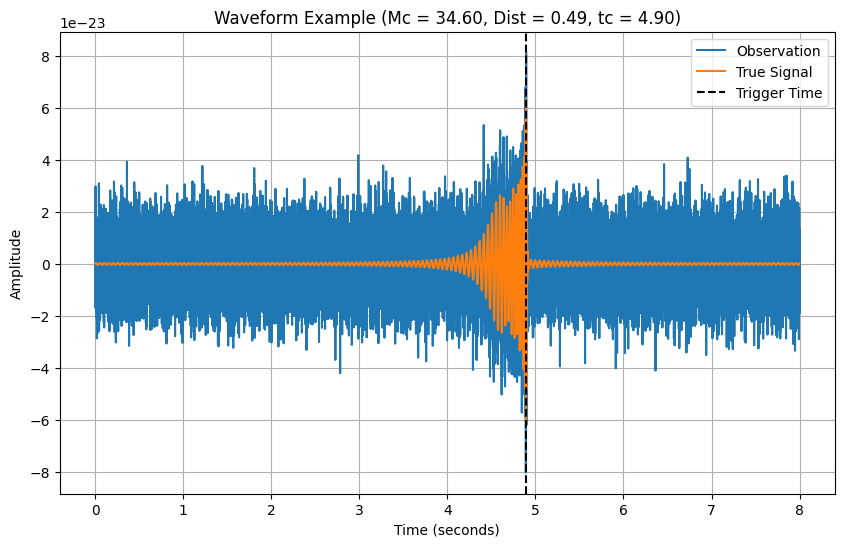

In [3]:
# Example usage for the first data point
sample_index = 119  # Choose the sample to plot
time = np.arange(len(data_set[sample_index])) / srate  # Time vector in seconds
amplitude = data_set[sample_index]
true_signal = signal_set[sample_index]
tc_trigger = theta_set[sample_index, 2] # Extract tc value
Mc, dist_gpc, tc = theta_set[sample_index]

plt.figure(figsize=(10, 6))
plt.plot(time, amplitude, label='Observation')
plt.plot(time, true_signal, label='True Signal')
plt.axvline(x=tc_trigger, color='black', linestyle='--', label='Trigger Time')
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"Waveform Example (Mc = {Mc:.2f}, Dist = {dist_gpc:.2f}, tc = {tc:.2f})")
plt.grid(True)
plt.show()


#### Preprocess and create data loaders

In [4]:
# Preprocess
data_set_rescaled = data_set / rescale_factor
signal_set_rescaled = signal_set / rescale_factor

# Normalize the data
#mean_data = np.mean(data_set, axis=0)
#std_data = np.std(data_set, axis=0)
#data_set = (data_set - mean_data) / std_data

split_train_idx = int(0.80 * num_data)  # End of train
split_val_idx   = int(0.95 * num_data)  # End of validation (start of test)

# We will add observational noise to the signal on the fly during training to prevent overfitting.
# Train
train_params = torch.from_numpy(theta_set[:split_train_idx]).float()
train_input  = torch.from_numpy(signal_set_rescaled[:split_train_idx]).float()[:, None]

# Validation
valid_params = torch.from_numpy(theta_set[split_train_idx:split_val_idx]).float()
valid_input  = torch.from_numpy(signal_set_rescaled[split_train_idx:split_val_idx]).float()[:, None]

# Test
test_params = torch.from_numpy(theta_set[split_val_idx:]).float()
test_input  = torch.from_numpy(signal_set_rescaled[split_val_idx:]).float()[:, None]

batch_size = 32

train_dataset = TensorDataset(train_params, train_input)
valid_dataset = TensorDataset(valid_params, valid_input)
test_dataset  = TensorDataset(test_params,  test_input)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

#### Copy-Paste and Adapt SBI Methods

You can copy and paste SBI methods from the previous Ciela notebook to solve these inference problems. For example, in the following section, we copy-pasted the source code to perform Neural Posterior Estimation using the full data, i.e., without compressed statistics.

However, the neural network architecture must be adapted to accept 1D time series data as input, and the data must be preprocessed to ensure the network can handle the extremely low amplitude values of the signal. (Hint: rescaling or normalizing the input data would be best.)

#### Example: NPE without Compressed Statistics

Epoch [1/200] | Train Loss: 99.5277 | Val Loss: 18.1426
Epoch [2/200] | Train Loss: 8.7461 | Val Loss: 7.3111
Epoch [3/200] | Train Loss: 5.9387 | Val Loss: 5.6562
Epoch [4/200] | Train Loss: 4.9163 | Val Loss: 4.7574
Epoch [5/200] | Train Loss: 4.2198 | Val Loss: 4.0040
Epoch [6/200] | Train Loss: 3.7000 | Val Loss: 3.6604
Epoch [7/200] | Train Loss: 3.3998 | Val Loss: 3.3339
Epoch [8/200] | Train Loss: 3.1873 | Val Loss: 3.3743
Epoch [9/200] | Train Loss: 3.1242 | Val Loss: 3.2561
Epoch [10/200] | Train Loss: 3.0425 | Val Loss: 3.0515
Epoch [11/200] | Train Loss: 2.9491 | Val Loss: 3.2504
Epoch [12/200] | Train Loss: 2.8546 | Val Loss: 3.2325
Epoch [13/200] | Train Loss: 2.8347 | Val Loss: 3.2603
Epoch [14/200] | Train Loss: 2.7890 | Val Loss: 3.7343
Epoch [15/200] | Train Loss: 2.6957 | Val Loss: 3.1952
Epoch [16/200] | Train Loss: 2.6534 | Val Loss: 3.8428
Epoch [17/200] | Train Loss: 2.6220 | Val Loss: 2.8623
Epoch [18/200] | Train Loss: 2.5811 | Val Loss: 3.0506
Epoch [19/200] | 

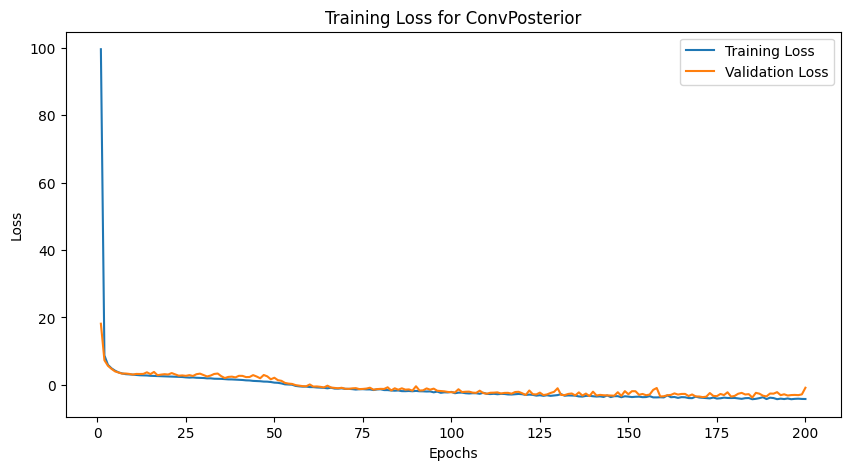

In [9]:
class ConvPosterior1D(nn.Module):
    """
    A 1D convolutional network to predict the mean and log variance of the model parameters
    from a time series of length 16384 (downsampling by 4 each time).
    """
    def __init__(self, input_length=16384, in_channels=1, latent_dim=3, output_dim=6):
        super().__init__()
        self.input_length = input_length
        self.in_channels  = in_channels
        self.latent_dim   = latent_dim
        self.output_dim   = output_dim

        # -------------------------
        #   Encoder (1D)
        # -------------------------
        # Each conv uses stride=4 to downsample by 4 each time.
        # 16384 => 4096 => 1024 => 256 => 64 => 16 => 4 => 1
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels,   8,  kernel_size=3, stride=4, padding=1),  # -> [B,   8,  4096]
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.Conv1d(8,   16, kernel_size=3, stride=4, padding=1),            # -> [B,  16,  1024]
            nn.BatchNorm1d(16),
            nn.ReLU(True),

            nn.Conv1d(16,  32, kernel_size=3, stride=4, padding=1),            # -> [B,  32,   256]
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.Conv1d(32,  64, kernel_size=3, stride=4, padding=1),            # -> [B,  64,    64]
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.Conv1d(64,  128, kernel_size=3, stride=4, padding=1),           # -> [B, 128,    16]
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.Conv1d(128, 256, kernel_size=3, stride=4, padding=1),           # -> [B, 256,     4]
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.Conv1d(256, 512, kernel_size=3, stride=4, padding=1),           # -> [B, 512,     1]
            nn.BatchNorm1d(512),
            nn.ReLU(True),
        )

        # After final conv, the shape is [B, 512, 1]. Flatten to [B, 512].
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        """
        x shape: [B, in_channels, input_length], e.g. [B, 1, 16384]
        """
        x = self.encoder(x)                # -> [B, 512, 1]
        x = x.view(x.size(0), -1)          # flatten to [B, 512]
        x = torch.relu(self.fc1(x))        # -> [B, 128]
        x = self.fc2(x)                    # -> [B, output_dim]
        mean = x[:, : self.output_dim // 2]
        log_var = x[:, self.output_dim // 2 :]
        return mean, log_var

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

posterior_conv_model = ConvPosterior1D(
    input_length=seglen_upfactor * seglen * srate,
    in_channels=1,
    latent_dim=3,     # e.g. 3
    output_dim=6      # must be 2 * latent_dim if you are predicting mean+log_var
).to(device)

# Negative log-likelihood
def negative_log_likelihood(mean, log_var, true_params):
    var = torch.exp(log_var)
    nll = 0.5 * torch.sum(log_var + (true_params - mean)**2 / var, dim=1)
    return torch.mean(nll)

# Set up optimizer
posterior_optimizer = optim.Adam(posterior_conv_model.parameters(), lr=1e-4)

# Training loop
posterior_epochs = 200
posterior_train_losses = []
posterior_valid_losses = []



for epoch in range(1, posterior_epochs + 1):
    posterior_conv_model.train()
    running_train_loss = 0.0
    for (params, input_data) in train_loader:
        params = params.to(device)
        input_data = input_data.to(device)

        # Add observation noise randomly on the fly
        noise = torch.randn_like(input_data) * sigma_noise
        input_data = input_data + noise

        posterior_optimizer.zero_grad()
        mean, log_var = posterior_conv_model(input_data)

        loss = negative_log_likelihood(mean, log_var, params)
        loss.backward()
        posterior_optimizer.step()

        running_train_loss += loss.item() * params.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    posterior_train_losses.append(epoch_train_loss)

    # Validation
    posterior_conv_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for (params, input_data) in valid_loader:
            params = params.to(device)
            input_data = input_data.to(device)

            # Add observation noise randomly on the fly
            noise = torch.randn_like(input_data) * sigma_noise
            input_data = input_data + noise

            mean, log_var = posterior_conv_model(input_data)
            loss = negative_log_likelihood(mean, log_var, params)
            running_val_loss += loss.item() * params.size(0)
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    posterior_valid_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch}/{posterior_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, posterior_epochs + 1), posterior_train_losses, label='Training Loss')
plt.plot(range(1, posterior_epochs + 1), posterior_valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for ConvPosterior')
plt.legend()
plt.show()

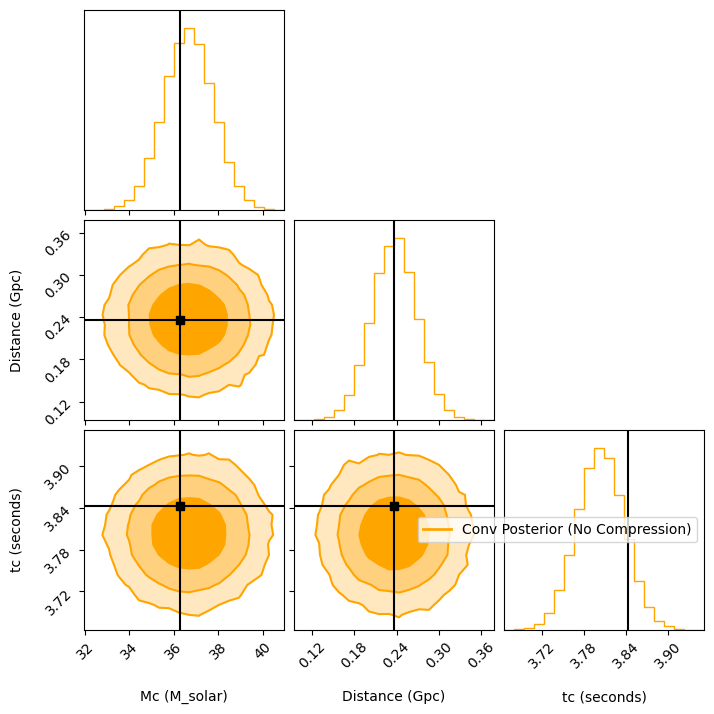

In [13]:
# Generate samples from the learned posterior neural network
posterior_conv_model.eval()

test_index = 20
true_signal = test_input[test_index][None].to(device)
noise = torch.randn_like(true_signal) * sigma_noise # add observation noise
obs_signal = true_signal + noise

true_params = test_params[test_index].detach().cpu().numpy()

with torch.no_grad():
    mean, log_var = posterior_conv_model(obs_signal.to(device))
    var = torch.exp(log_var)
    std = torch.sqrt(var)
    posterior_conv_samples = mean + std * torch.randn(100000, mean.size(1)).to(device)
    posterior_conv_samples = posterior_conv_samples.detach().cpu().numpy()

# Plot the MCMC samples, the posterior neural network samples, and the likelihood + MCMC samples
#fig = corner.corner(posterior_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='green', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior NN Samples', truth_color='black')
#corner.corner(likelihood_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='blue', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Likelihood NN + MCMCs', truth_color='black')
fig = corner.corner(posterior_conv_samples, labels=["Mc (M_solar)", "Distance (Gpc)", "tc (seconds)"], truths=true_params, color='orange', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior Conv (No Compression)', truth_color='black')
#corner.corner(analytic_samples, labels=["x", "y", "sigma"], truths=true_params, color='red', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='MCMC Samples', truth_color='black')
# plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=2, label='Amortized Posterior (Compression)'),
#                     plt.Line2D([0], [0], color='blue', lw=2, label='Amortized Likelihood (Compression)'),
#                     plt.Line2D([0], [0], color='orange', lw=2, label='Conv Posterior (No Compression)'),
#                     plt.Line2D([0], [0], color='red', lw=2, label='True Posterior')],
#           loc='upper right', bbox_to_anchor=(1.0, 2.7))
plt.legend(handles=[plt.Line2D([0], [0], color='orange', lw=2, label='Conv Posterior (No Compression)')])
plt.show()

## Strong Gravitational Lensing Inference Example

In [3]:
import torch
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

!pip install caustics
import caustics
from caustics import Module, forward, Param, LensSource, SIE, Sersic, FlatLambdaCDM
from torch.nn.functional import conv2d, avg_pool2d
from torch.func import vmap

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

!pip install emcee corner --quiet
import emcee
import corner

from torch.distributions.multivariate_normal import MultivariateNormal

In [4]:
# Define parameters of the camera pixel grid
pixelscale = 0.2  # arcsec/pixel
pixels = 32

# Instantiate modules for the simulator
cosmo = FlatLambdaCDM(name="cosmo")
lens = SIE(cosmology=cosmo, name="lens")
source = Sersic(name="source")
simulator = LensSource(lens, source, pixelscale=pixelscale, pixels_x=pixels)

simulator.lens.Rein = None
simulator.source.Ie = None
simulator.lens.x0 = 0.
simulator.lens.y0 = 0.
simulator.source.x0 = 0.
simulator.source.y0 = 0.
simulator.source.n = 2.0
simulator.source.Re = 1.0
simulator.lens.q = None
simulator.source.q = None
simulator.lens.phi = None
simulator.source.phi = None
simulator.lens.z_s = 1.5
simulator.lens.z_l = 0.5

In [5]:
def sample_prior(n_samples, device="cpu"):
    """
    Returns two tensors (lens_params, source_params), each of shape (n_samples, 3).
    lens_params = [q, phi, Rein]
    source_params = [q, phi, Ie]
    """
    rng = np.random.default_rng()

    # lens: q, phi, Rein
    lens_q = rng.uniform(0.5, 0.8, size=n_samples)
    lens_phi = rng.uniform(-np.pi, np.pi, size=n_samples)
    lens_Rein = rng.uniform(0.7, 2.0, size=n_samples)

    lens_params = torch.tensor(
        np.column_stack([lens_q, lens_phi, lens_Rein]),
        dtype=torch.float32, device=device
    )

    # source: q, phi, Ie
    source_q = rng.uniform(0.5, 0.8, size=n_samples)
    source_phi = rng.uniform(-np.pi, np.pi, size=n_samples)
    source_Ie = rng.uniform(5.0, 20.0, size=n_samples)

    source_params = torch.tensor(
        np.column_stack([source_q, source_phi, source_Ie]),
        dtype=torch.float32, device=device
    )

    return lens_params, source_params


# 3) Sample the prior and generate a batch of lensed images
n_samples = 5  # for example
lens_params_batch, source_params_batch = sample_prior(n_samples)

y = vmap(simulator)([lens_params_batch, source_params_batch])
print("Generated image batch shape:", y.shape)

Generated image batch shape: torch.Size([5, 32, 32])


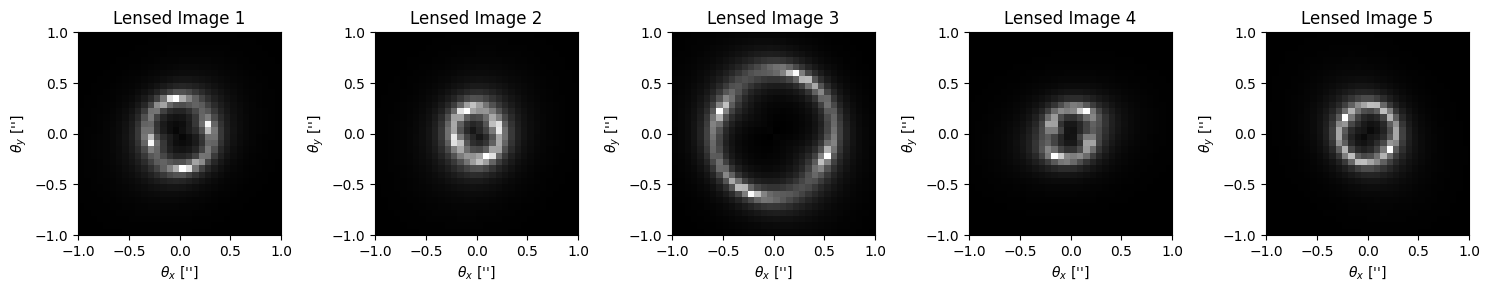

In [6]:
fig, axes = plt.subplots(1, n_samples, figsize=(15, 4))

for i in range(n_samples):
    axes[i].imshow(y[i], origin="lower", extent=(-1, 1, -1, 1), cmap="gray")
    axes[i].set_title(f"Lensed Image {i+1}")
    axes[i].set_ylabel(r"$\theta_y$ ['']")
    axes[i].set_xlabel(r"$\theta_x$ ['']")

plt.tight_layout()
plt.show()


In [7]:
def build_dataset_in_chunks(num_data=5000, chunk_size=256, device="cpu"):
    """
    Generate (num_data) samples in batches of (chunk_size), store them,
    compute a single global mean/std, normalize all images, then split
    into train/val/test. Return DataLoaders for each split.
    """

    # These lists will temporarily hold the chunks of data in memory
    images_list  = []
    params_list  = []

    # Generate samples in chunks to avoid excessive memory usage in one shot
    n_done = 0
    while n_done < num_data:
        n_batch = min(chunk_size, num_data - n_done)

        # 1) Sample random lens/source parameters
        lens_params, source_params = sample_prior(n_batch, device=device)

        # 2) Evaluate the simulator in a vectorized manner
        #    shape: (n_batch, H, W) or (n_batch, ..., H, W)
        images_chunk = vmap(simulator)([lens_params, source_params])

        # 3) Concatenate lens & source parameters into one (n_batch, 6) tensor
        #    lens: [q, phi, Rein], source: [q, phi, Ie]
        chunk_params = torch.cat([lens_params, source_params], dim=1)

        # Move to CPU if needed, then store
        images_list.append(images_chunk.cpu())
        params_list.append(chunk_params.cpu())

        n_done += n_batch

    # Concatenate all chunks into a single tensor
    images_tensor = torch.cat(images_list, dim=0)   # shape (num_data, H, W)
    params_tensor = torch.cat(params_list, dim=0)   # shape (num_data, 6)

    # Optionally expand images to (N, 1, H, W) for CNN input
    images_tensor = images_tensor.unsqueeze(1)      # shape (num_data, 1, H, W)

    # 4) Compute a single mean & std over *all* pixels, across entire dataset
    #    Flatten so we can get a single scalar mean/std
    flat = images_tensor.view(images_tensor.size(0), -1).float()
    global_mean = flat.mean()
    global_std  = flat.std()
    # safeguard against zero
    if global_std < 1e-12:
        global_std = 1e-12

    # 5) Normalize the images with that global mean & std
    images_tensor = (images_tensor - global_mean) / global_std

    # 6) Split into train/val/test
    #    e.g. 80% / 15% / 5%
    split_train_idx = int(0.80 * num_data)
    split_val_idx   = int(0.95 * num_data)

    train_params_t  = params_tensor[:split_train_idx]
    train_images_t  = images_tensor[:split_train_idx]

    valid_params_t  = params_tensor[split_train_idx:split_val_idx]
    valid_images_t  = images_tensor[split_train_idx:split_val_idx]

    test_params_t   = params_tensor[split_val_idx:]
    test_images_t   = images_tensor[split_val_idx:]

    # 7) Wrap into TensorDatasets
    train_dataset = TensorDataset(train_images_t, train_params_t)
    valid_dataset = TensorDataset(valid_images_t, valid_params_t)
    test_dataset  = TensorDataset(test_images_t, test_params_t)

    # 8) DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader, (global_mean.item(), global_std.item())

num_data = 1000     # total dataset size
chunk_size = 256    # how many to generate at a time
train_loader, valid_loader, test_loader, (mean_val, std_val) = build_dataset_in_chunks(
    num_data=num_data, chunk_size=chunk_size
)

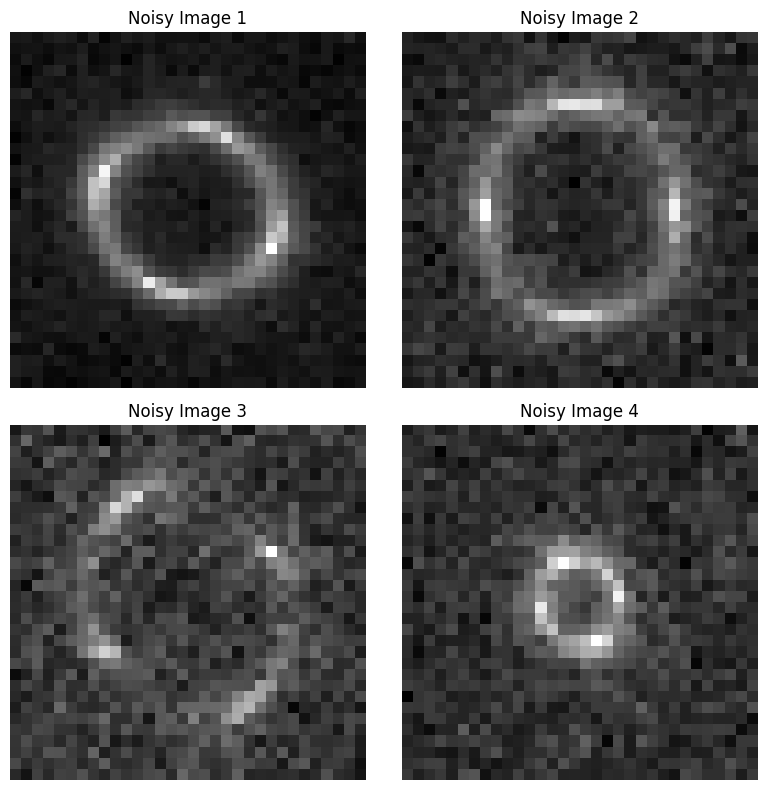

In [8]:
def add_white_noise(image, noise_factor=0.35):
    noise = np.random.normal(0, 1, size=image.shape) * noise_factor
    return image + noise

# We'll plot four noisy images in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()  # so we can index them as axes[0] ... axes[3]

count = 0
for images, params in train_loader:   # (images is shape [batch_size, C, H, W])
    # Go through each item in this batch
    for b in range(images.size(0)):
        # Convert to numpy
        image = images[b].squeeze().numpy()  # shape [H, W] if C=1
        noisy_image = add_white_noise(image)

        # Plot on the appropriate subplot
        axes[count].imshow(noisy_image, cmap="gray")
        axes[count].set_title(f"Noisy Image {count+1}")
        axes[count].axis("off")

        count += 1
        if count == 4:
            break  # we've plotted our 4 images
    if count == 4:
        break

plt.tight_layout()
plt.show()

#### Example: NPE without Neural Compression

Epoch [1/150] | Train Loss: 9.7440 | Val Loss: 3.4719
Epoch [2/150] | Train Loss: 1.8636 | Val Loss: 1.4182
Epoch [3/150] | Train Loss: -0.0373 | Val Loss: -0.1988
Epoch [4/150] | Train Loss: -0.4887 | Val Loss: -0.3431
Epoch [5/150] | Train Loss: -0.7548 | Val Loss: -0.1576
Epoch [6/150] | Train Loss: -0.6317 | Val Loss: -1.2702
Epoch [7/150] | Train Loss: -1.3069 | Val Loss: -1.2287
Epoch [8/150] | Train Loss: -1.1865 | Val Loss: -1.5794
Epoch [9/150] | Train Loss: -1.2593 | Val Loss: -1.5845
Epoch [10/150] | Train Loss: -1.0652 | Val Loss: -1.2657
Epoch [11/150] | Train Loss: -1.7643 | Val Loss: -2.0692
Epoch [12/150] | Train Loss: -1.5891 | Val Loss: -1.8031
Epoch [13/150] | Train Loss: -2.0484 | Val Loss: -2.0157
Epoch [14/150] | Train Loss: -2.4486 | Val Loss: -2.5998
Epoch [15/150] | Train Loss: -2.3683 | Val Loss: -2.5091
Epoch [16/150] | Train Loss: -2.1457 | Val Loss: -2.2456
Epoch [17/150] | Train Loss: -2.4990 | Val Loss: -2.9013
Epoch [18/150] | Train Loss: -2.5353 | Val L

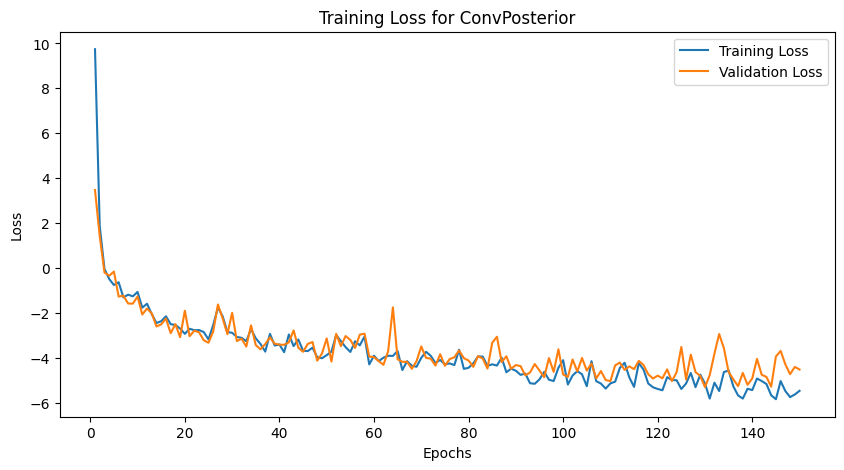

In [10]:
class ConvPosterior(nn.Module):
    """
    A convolutional network to predict the mean and log variance of the model parameters.
    """
    def __init__(self, image_size=32, latent_dim=6, output_dim=12):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.output_dim = output_dim

        # -------------------------
        #   Encoder
        # -------------------------
        self.encoder = nn.Sequential(
            nn.Conv2d(1,  8,  kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),

            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        mean = x[:, :self.output_dim//2]
        log_var = x[:, self.output_dim//2:]
        return mean, log_var

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
posterior_conv_model = ConvPosterior(image_size=32, latent_dim=6, output_dim=12).to(device)

# Loss and optimizer
posterior_optimizer = optim.Adam(posterior_conv_model.parameters(), lr=1e-3)

def negative_log_likelihood(mean, log_var, true_params):
    var = torch.exp(log_var)
    nll = 0.5 * torch.sum(log_var + (true_params - mean)**2 / var, dim=1)
    return torch.mean(nll)

# Observation Noise sigma level
sigma_noise = 0.35

# Training loop
posterior_epochs = 150
posterior_train_losses = []
posterior_valid_losses = []

for epoch in range(1, posterior_epochs + 1):
    posterior_conv_model.train()
    running_train_loss = 0.0
    for (input_data, params) in train_loader:
        params = params.to(device)
        input_data = input_data.to(device)

        # Add observation noise randomly on the fly
        noise = torch.randn_like(input_data) * sigma_noise
        input_data = input_data + noise

        posterior_optimizer.zero_grad()
        mean, log_var = posterior_conv_model(input_data)

        loss = negative_log_likelihood(mean, log_var, params)
        loss.backward()
        posterior_optimizer.step()

        running_train_loss += loss.item() * params.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    posterior_train_losses.append(epoch_train_loss)

    # Validation
    posterior_conv_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for (input_data, params) in valid_loader:
            params = params.to(device)
            input_data = input_data.to(device)

            # Add observation noise randomly on the fly
            noise = torch.randn_like(input_data) * sigma_noise
            input_data = input_data + noise

            mean, log_var = posterior_conv_model(input_data)
            loss = negative_log_likelihood(mean, log_var, params)
            running_val_loss += loss.item() * params.size(0)
    epoch_val_loss = running_val_loss / len(valid_loader.dataset)
    posterior_valid_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch}/{posterior_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, posterior_epochs + 1), posterior_train_losses, label='Training Loss')
plt.plot(range(1, posterior_epochs + 1), posterior_valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for ConvPosterior')
plt.legend()
plt.show()

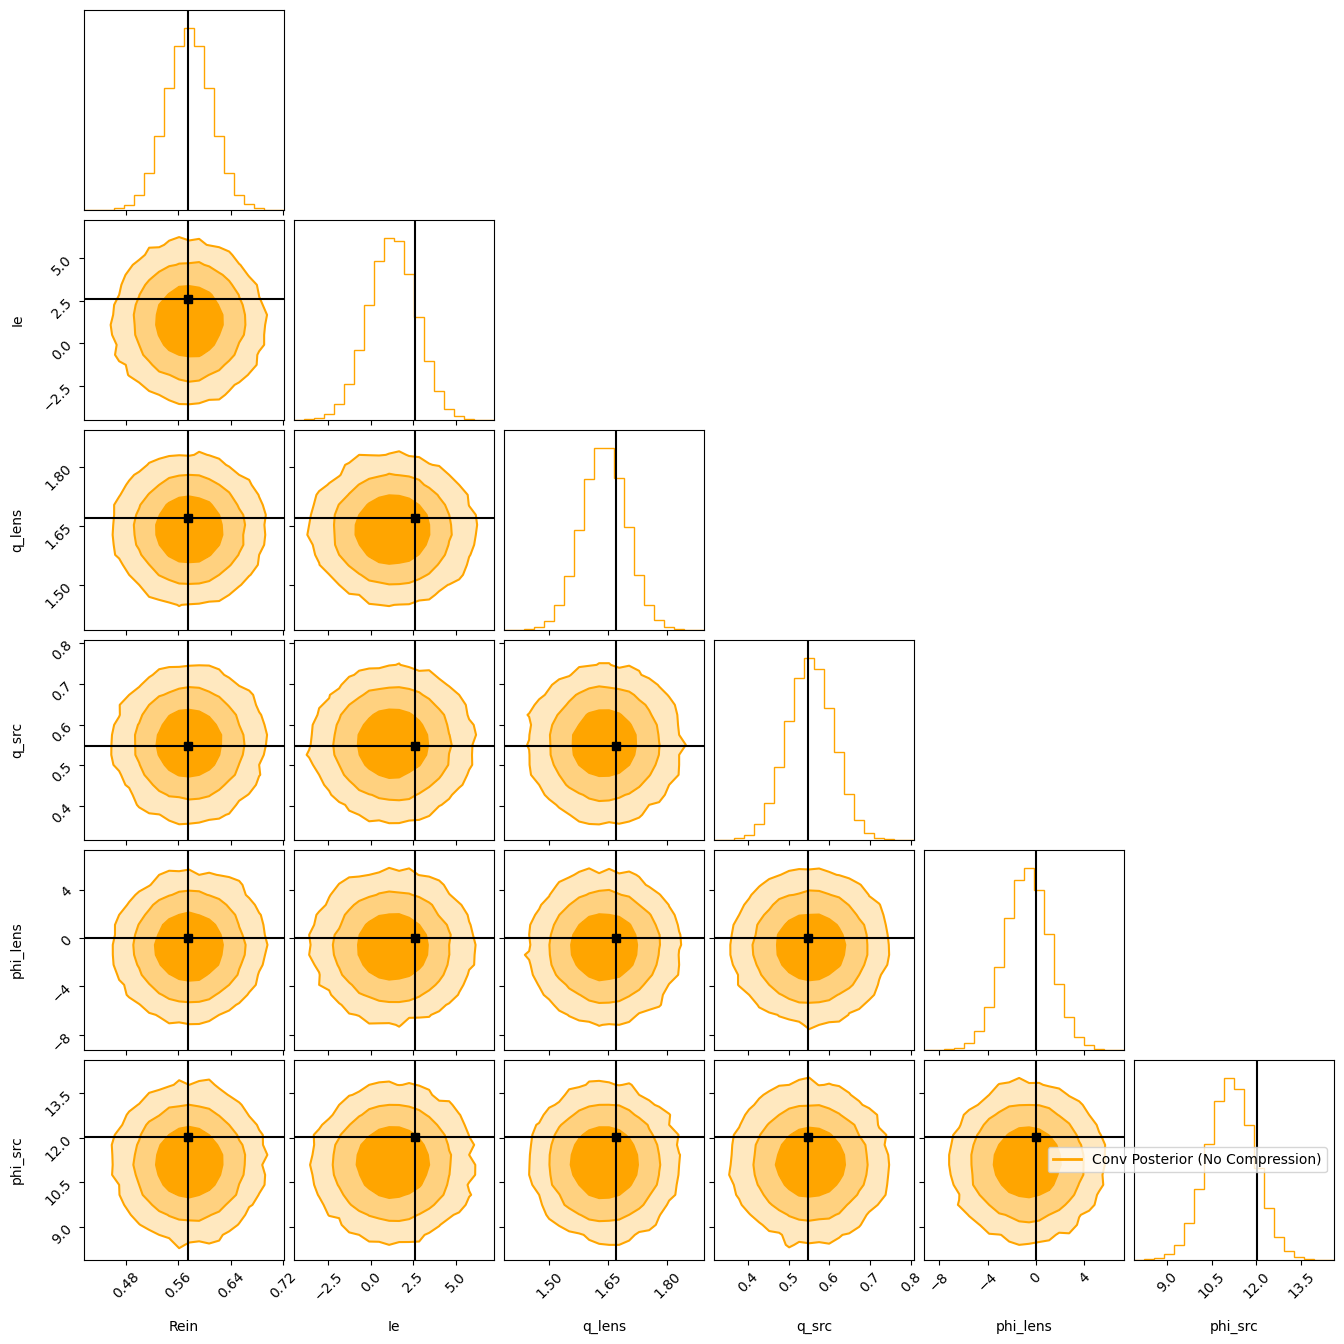

In [12]:
# Generate samples from the learned posterior neural network
posterior_conv_model.eval()

test_index = 20
true_image = test_loader.dataset[test_index][0][None].to(device)
noise = torch.randn_like(true_image) * sigma_noise # add observation noise
obs_image = true_image + noise

true_params = test_loader.dataset[test_index][1].detach().cpu().numpy()

with torch.no_grad():
    mean, log_var = posterior_conv_model(obs_image.to(device))
    var = torch.exp(log_var)
    std = torch.sqrt(var)
    posterior_conv_samples = mean + std * torch.randn(100000, mean.size(1)).to(device)
    posterior_conv_samples = posterior_conv_samples.detach().cpu().numpy()

# Plot the MCMC samples, the posterior neural network samples, and the likelihood + MCMC samples
#fig = corner.corner(posterior_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='green', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior NN Samples', truth_color='black')
#corner.corner(likelihood_nn_samples, labels=["x", "y", "sigma"], truths=true_params, color='blue', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Likelihood NN + MCMCs', truth_color='black')
fig = corner.corner(posterior_conv_samples, labels=["Rein", "Ie", "q_lens", "q_src", "phi_lens", "phi_src"], truths=true_params, color='orange', plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='Posterior Conv (No Compression)', truth_color='black')
#corner.corner(analytic_samples, labels=["x", "y", "sigma"], truths=true_params, color='red', fig=fig, plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95, 0.997], smooth=0.0, label='MCMC Samples', truth_color='black')
# plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=2, label='Amortized Posterior (Compression)'),
#                     plt.Line2D([0], [0], color='blue', lw=2, label='Amortized Likelihood (Compression)'),
#                     plt.Line2D([0], [0], color='orange', lw=2, label='Conv Posterior (No Compression)'),
#                     plt.Line2D([0], [0], color='red', lw=2, label='True Posterior')],
#           loc='upper right', bbox_to_anchor=(1.0, 2.7))
plt.legend(handles=[plt.Line2D([0], [0], color='orange', lw=2, label='Conv Posterior (No Compression)')])
plt.show()